In [1]:
# Step 1: Install required packages
!pip install -q transformers datasets accelerate peft bitsandbytes torch
!pip install -q --upgrade transformers[torch] datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 27.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [2]:
import os
import json
import torch
import re
import sys
import traceback
import signal
from io import StringIO
from contextlib import redirect_stdout, redirect_stderr
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import PeftModel
from huggingface_hub import hf_hub_download, login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import warnings
warnings.filterwarnings("ignore")

2025-08-25 08:10:57.641996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756109457.817387      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756109457.865650      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# =====================================================================
# STEP 1: Configuration and Setup
# =====================================================================

class EvaluationConfig:
    # Model paths
    base_model_name = "codellama/CodeLlama-7b-Instruct-hf"
    finetuned_model_path = "/kaggle/input/modelv2/codellama-apps-finetuned"  # Update this path
    
    # Dataset configuration
    dataset_name = "codeparrot/apps"
    
    # Evaluation parameters
    eval_samples = 100  # Medium-sized evaluation for good results
    code_timeout = 10
    max_retries = 2
    
    # Generation parameters
    max_new_tokens = 300
    temperature = 0.6
    top_p = 0.92
    top_k = 40
    
    # Quantization for memory efficiency
    use_4bit = True
    bnb_4bit_compute_dtype = "float16"
    bnb_4bit_quant_type = "nf4"

config = EvaluationConfig()

print("🚀 Starting Model Evaluation")
print(f"Base Model: {config.base_model_name}")
print(f"Fine-tuned Model: {config.finetuned_model_path}")
print(f"Evaluation Samples: {config.eval_samples}")

🚀 Starting Model Evaluation
Base Model: codellama/CodeLlama-7b-Instruct-hf
Fine-tuned Model: /kaggle/input/modelv2/codellama-apps-finetuned
Evaluation Samples: 100


In [5]:
# =====================================================================
# STEP 2: Code Execution Utilities
# =====================================================================

class TimeoutError(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutError("Code execution timed out")

def execute_with_timeout(func, timeout_seconds):
    """Execute function with timeout (Linux only)"""
    if hasattr(signal, 'SIGALRM'):
        old_handler = signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout_seconds)
        
        try:
            result = func()
            signal.alarm(0)
            return result
        except TimeoutError:
            raise
        finally:
            signal.signal(signal.SIGALRM, old_handler)
    else:
        return func()

def execute_code_safely(code, test_input):
    """Execute code with timeout and capture output"""
    def run_code():
        stdout_capture = StringIO()
        stderr_capture = StringIO()
        
        try:
            safe_globals = {
                '__builtins__': {
                    'input': lambda: '',
                    'print': print,
                    'int': int, 'float': float, 'str': str, 'bool': bool,
                    'len': len, 'range': range, 'sum': sum,
                    'max': max, 'min': min, 'abs': abs, 'pow': pow,
                    'sorted': sorted, 'reversed': reversed,
                    'list': list, 'dict': dict, 'set': set, 'tuple': tuple,
                    'enumerate': enumerate, 'zip': zip,
                    'map': map, 'filter': filter,
                    'any': any, 'all': all,
                    'round': round, 'divmod': divmod,
                    'ord': ord, 'chr': chr,
                    'isinstance': isinstance, 'type': type
                },
                'math': __import__('math'),
                'itertools': __import__('itertools'),
                'collections': __import__('collections')
            }
            
            # Mock input function
            if test_input:
                input_lines = test_input.strip().split('\n')
                input_index = [0]
                
                def mock_input():
                    if input_index[0] < len(input_lines):
                        result = input_lines[input_index[0]]
                        input_index[0] += 1
                        return result
                    return ""
                
                safe_globals['__builtins__']['input'] = mock_input
            
            with redirect_stdout(stdout_capture), redirect_stderr(stderr_capture):
                exec(code, safe_globals)
                
            return {
                "success": True,
                "stdout": stdout_capture.getvalue(),
                "stderr": stderr_capture.getvalue(),
                "error": None
            }
            
        except Exception as e:
            return {
                "success": False,
                "stdout": stdout_capture.getvalue(),
                "stderr": stderr_capture.getvalue(),
                "error": str(e)
            }
    
    try:
        result = execute_with_timeout(run_code, config.code_timeout)
        return result
    except TimeoutError:
        return {
            "success": False,
            "stdout": "",
            "stderr": "",
            "error": "Code execution timed out"
        }
    except Exception as e:
        return {
            "success": False,
            "stdout": "",
            "stderr": "",
            "error": f"Execution error: {str(e)}"
        }

def verify_code_solution(code, input_output_data):
    """Verify code solution against test cases"""
    if not input_output_data or 'inputs' not in input_output_data:
        return {"verified": False, "error": "No test cases available", "score": 0.0}
    
    inputs = input_output_data['inputs'][:3]  # Test first 3 cases for speed
    outputs = input_output_data.get('outputs', [])
    results = []
    passed = 0
    
    for i, test_input in enumerate(inputs):
        try:
            result = execute_code_safely(code, test_input)
            results.append(result)
            
            if result["success"]:
                if i < len(outputs):
                    actual_output = result["stdout"].strip()
                    expected_output = outputs[i].strip()
                    if actual_output == expected_output:
                        passed += 1
                    else:
                        result["output_mismatch"] = {
                            "expected": expected_output,
                            "actual": actual_output
                        }
                else:
                    passed += 1
            
        except Exception as e:
            results.append({
                "success": False,
                "error": f"Verification error: {str(e)}"
            })
    
    score = passed / len(inputs) if inputs else 0.0
    verified = score >= 0.67  # 2/3 pass rate for verification
    
    return {
        "verified": verified,
        "score": score,
        "passed": passed,
        "total": len(inputs),
        "test_results": results
    }

In [6]:
# =====================================================================
# STEP 3: Load Dataset (Alternative Approach)
# =====================================================================

print("📥 Loading APPS dataset using alternative approach...")

try:
    cache_dir = "./apps_cache"
    os.makedirs(cache_dir, exist_ok=True)
    
    print("Downloading dataset files...")
    test_file = hf_hub_download(
        repo_id="codeparrot/apps",
        filename="test.jsonl",
        repo_type="dataset",
        local_dir=cache_dir
    )
    
    def load_jsonl(file_path):
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
        return data
    
    print("Processing dataset files...")
    test_data = load_jsonl(test_file)
    
    # Filter and sample data
    def enhanced_filter(example):
        try:
            difficulty = example.get('difficulty', 'unknown')
            if difficulty not in ['introductory', 'interview', 'competition']:
                return False
                
            solutions = json.loads(example.get('solutions', '[]'))
            if not solutions or not solutions[0].strip():
                return False
                
            return len(solutions[0]) > 20 and len(solutions[0]) < 1000
        except:
            return False
    
    # Filter and sample
    filtered_data = [ex for ex in test_data if enhanced_filter(ex)]
    
    # Stratified sampling by difficulty
    by_difficulty = {}
    for ex in filtered_data:
        diff = ex.get('difficulty', 'interview')
        if diff not in by_difficulty:
            by_difficulty[diff] = []
        by_difficulty[diff].append(ex)
    
    eval_data = []
    samples_per_difficulty = config.eval_samples // 3
    
    for diff, examples in by_difficulty.items():
        if examples:
            import random
            random.shuffle(examples)
            eval_data.extend(examples[:samples_per_difficulty])
    
    # Fill remaining slots
    if len(eval_data) < config.eval_samples:
        remaining = [ex for diff_list in by_difficulty.values() 
                    for ex in diff_list if ex not in eval_data]
        random.shuffle(remaining)
        eval_data.extend(remaining[:config.eval_samples - len(eval_data)])
    
    eval_dataset = eval_data[:config.eval_samples]
    print(f"✅ Evaluation dataset loaded: {len(eval_dataset)} samples")
    
    # Distribution by difficulty
    difficulty_counts = {}
    for ex in eval_dataset:
        diff = ex.get('difficulty', 'unknown')
        difficulty_counts[diff] = difficulty_counts.get(diff, 0) + 1
    
    print("📊 Dataset distribution:")
    for diff, count in difficulty_counts.items():
        print(f"  {diff}: {count} samples")

except Exception as e:
    print(f"❌ Failed to load dataset: {e}")
    sys.exit(1)

📥 Loading APPS dataset using alternative approach...


test.jsonl:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Processing dataset files...
✅ Evaluation dataset loaded: 100 samples
📊 Dataset distribution:
  interview: 33 samples
  competition: 33 samples
  introductory: 34 samples


In [7]:
# =====================================================================
# STEP 4: Model Loading
# =====================================================================

print("\n🔧 Setting up quantization configuration...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=config.use_4bit,
    bnb_4bit_quant_type=config.bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=getattr(torch, config.bnb_4bit_compute_dtype),
    bnb_4bit_use_double_quant=True,
)

print("📥 Loading base model...")
base_tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_name,
    trust_remote_code=True,
    padding_side="right"
)
if base_tokenizer.pad_token is None:
    base_tokenizer.pad_token = base_tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)
print("✅ Base model loaded successfully!")

print("📥 Loading fine-tuned model...")
try:
    # Load tokenizer (should be same as base)
    finetuned_tokenizer = AutoTokenizer.from_pretrained(
        config.finetuned_model_path,
        trust_remote_code=True,
        padding_side="right"
    )
    if finetuned_tokenizer.pad_token is None:
        finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token
    
    # Try to load as PEFT model first
    try:
        finetuned_model = PeftModel.from_pretrained(
            base_model,
            config.finetuned_model_path,
            device_map="auto"
        )
        print("✅ Fine-tuned model loaded as PEFT model!")
    except:
        # Fallback: load as regular model
        finetuned_model = AutoModelForCausalLM.from_pretrained(
            config.finetuned_model_path,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        print("✅ Fine-tuned model loaded as regular model!")
    
except Exception as e:
    print(f"❌ Error loading fine-tuned model: {e}")
    print("Using base model for both comparisons...")
    finetuned_model = base_model
    finetuned_tokenizer = base_tokenizer


🔧 Setting up quantization configuration...
📥 Loading base model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

✅ Base model loaded successfully!
📥 Loading fine-tuned model...
✅ Fine-tuned model loaded as PEFT model!


In [10]:
# =====================================================================
# STEP 5: Evaluation Pipeline
# =====================================================================

class ModelEvaluator:
    def __init__(self, model, tokenizer, model_name):
        self.model = model
        self.tokenizer = tokenizer
        self.model_name = model_name
        self.model.eval()
    
    def extract_code_from_response(self, response):
        """Extract code from model response"""
        if not response or not response.strip():
            return "# No response generated"
            
        patterns = [
            r'```python\s*(.*?)\s*```',
            r'```\s*(.*?)\s*```',
            r'\*\*Implementation:\*\*\s*```python\s*(.*?)\s*```',
            r'\*\*Code:\*\*\s*(.*?)(?=\n\n|\*\*|$)',
        ]
        
        for pattern in patterns:
            try:
                match = re.search(pattern, response, re.DOTALL | re.IGNORECASE)
                if match:
                    code = match.group(1).strip()
                    if self._is_valid_python_code(code):
                        return code
            except re.error as e:
                print(f"Regex error with pattern {pattern}: {e}")
                continue
        
        # Fallback extraction
        lines = response.strip().split('\n')
        code_lines = []
        in_code_block = False
        
        for line in lines:
            if any(keyword in line for keyword in ['def ', 'for ', 'if ', 'print(', 'input(', '=']):
                in_code_block = True
            
            if in_code_block:
                if line.startswith('**') or line.startswith('##'):
                    break
                code_lines.append(line)
        
        if code_lines:
            potential_code = '\n'.join(code_lines).strip()
            if self._is_valid_python_code(potential_code):
                return potential_code
        
        return "# No valid code found"
    
    def _is_valid_python_code(self, code):
        """Validate Python code"""
        if not code or len(code) < 10:
            return False
            
        try:
            compile(code, '<string>', 'exec')
        except SyntaxError:
            return False
        
        essential_patterns = ['input(', 'print(']
        if not any(pattern in code for pattern in essential_patterns):
            return False
            
        return True
    
    def generate_solution(self, problem_text):
        """Generate solution for a problem"""
        prompt = f"""Below is a programming problem. Provide a complete Python solution.

### Problem:
{problem_text}

### Solution:

**Implementation:**
```python"""
        
        try:
            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                max_length=800,
                truncation=True,
                padding=True
            )
            
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    max_new_tokens=config.max_new_tokens,
                    temperature=config.temperature,
                    do_sample=True,
                    top_p=config.top_p,
                    top_k=config.top_k,
                    repetition_penalty=1.1,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
            
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = generated_text.split("**Implementation:**")[-1].strip()
            
            return self.extract_code_from_response(response)
            
        except Exception as e:
            print(f"Generation error: {e}")
            return "# Generation failed"
    
    def evaluate_sample(self, sample):
        """Evaluate a single sample"""
        try:
            problem = sample['question']
            solutions = json.loads(sample['solutions'])
            difficulty = sample.get('difficulty', 'unknown')
            
            # Parse input/output data
            input_output_data = None
            try:
                input_output_data = json.loads(sample.get('input_output', '{}'))
            except:
                pass
            
            # Generate solution
            generated_code = self.generate_solution(problem)
            
            # Verify solution
            if input_output_data and generated_code != "# Generation failed":
                verification = verify_code_solution(generated_code, input_output_data)
            else:
                verification = {"verified": False, "score": 0.0, "error": "No test cases"}
            
            return {
                "problem": problem[:100] + "..." if len(problem) > 100 else problem,
                "difficulty": difficulty,
                "generated_code": generated_code,
                "verification": verification,
                "success": verification.get("verified", False),
                "score": verification.get("score", 0.0),
                "model_name": self.model_name
            }
            
        except Exception as e:
            return {
                "problem": "Error processing sample",
                "difficulty": "unknown",
                "generated_code": "# Error",
                "verification": {"verified": False, "score": 0.0, "error": str(e)},
                "success": False,
                "score": 0.0,
                "model_name": self.model_name
            }

In [12]:
# =====================================================================
# STEP 6: Run Evaluation
# =====================================================================

print("\n🧪 Starting evaluation...")

base_evaluator = ModelEvaluator(base_model, base_tokenizer, "Base Model")
finetuned_evaluator = ModelEvaluator(finetuned_model, finetuned_tokenizer, "Fine-tuned Model")

base_results = []
finetuned_results = []

print(f"Evaluating {len(eval_dataset)} samples...")

for i, sample in enumerate(eval_dataset):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(eval_dataset)} ({i/len(eval_dataset)*100:.1f}%)")
    
    # Evaluate with base model
    try:
        base_result = base_evaluator.evaluate_sample(sample)
        base_results.append(base_result)
    except Exception as e:
        print(f"Error evaluating sample {i} with base model: {e}")
        base_results.append({
            "success": False, "score": 0.0, "model_name": "Base Model",
            "problem": "Error", "difficulty": "unknown", "generated_code": "# Error"
        })
    
    # Evaluate with fine-tuned model
    try:
        finetuned_result = finetuned_evaluator.evaluate_sample(sample)
        finetuned_results.append(finetuned_result)
    except Exception as e:
        print(f"Error evaluating sample {i} with fine-tuned model: {e}")
        finetuned_results.append({
            "success": False, "score": 0.0, "model_name": "Fine-tuned Model",
            "problem": "Error", "difficulty": "unknown", "generated_code": "# Error"
        })

print("✅ Evaluation completed!")


🧪 Starting evaluation...
Evaluating 100 samples...
Progress: 0/100 (0.0%)
Progress: 10/100 (10.0%)
Progress: 20/100 (20.0%)
Progress: 30/100 (30.0%)
Progress: 40/100 (40.0%)
Progress: 50/100 (50.0%)
Progress: 60/100 (60.0%)
Progress: 70/100 (70.0%)
Progress: 80/100 (80.0%)
Progress: 90/100 (90.0%)
✅ Evaluation completed!


In [13]:
# =====================================================================
# STEP 7: Calculate Metrics and Analysis
# =====================================================================

print("\n📊 Calculating metrics...")

def calculate_metrics(results):
    """Calculate comprehensive metrics"""
    total = len(results)
    successful = sum(1 for r in results if r['success'])
    failed = total - successful
    
    # Accuracy
    accuracy = successful / total if total > 0 else 0
    
    # False Negative Rate (problems that should have been solved but weren't)
    # For simplicity, we consider all problems as "solvable"
    false_negative_rate = failed / total if total > 0 else 0
    
    # Average score
    avg_score = sum(r['score'] for r in results) / total if total > 0 else 0
    
    # By difficulty
    by_difficulty = {}
    for result in results:
        diff = result['difficulty']
        if diff not in by_difficulty:
            by_difficulty[diff] = {'total': 0, 'successful': 0, 'scores': []}
        
        by_difficulty[diff]['total'] += 1
        if result['success']:
            by_difficulty[diff]['successful'] += 1
        by_difficulty[diff]['scores'].append(result['score'])
    
    # Calculate difficulty-wise metrics
    difficulty_metrics = {}
    for diff, data in by_difficulty.items():
        difficulty_metrics[diff] = {
            'accuracy': data['successful'] / data['total'] if data['total'] > 0 else 0,
            'avg_score': sum(data['scores']) / len(data['scores']) if data['scores'] else 0,
            'count': data['total']
        }
    
    return {
        'total_samples': total,
        'successful': successful,
        'failed': failed,
        'accuracy': accuracy,
        'false_negative_rate': false_negative_rate,
        'average_score': avg_score,
        'by_difficulty': difficulty_metrics
    }

# Calculate metrics for both models
base_metrics = calculate_metrics(base_results)
finetuned_metrics = calculate_metrics(finetuned_results)

print("✅ Metrics calculated!")


📊 Calculating metrics...
✅ Metrics calculated!


In [14]:
# =====================================================================
# STEP 8: Display Results
# =====================================================================

print("\n" + "="*60)
print("📈 EVALUATION RESULTS")
print("="*60)

print(f"\n🔸 BASE MODEL RESULTS:")
print(f"  Total Samples: {base_metrics['total_samples']}")
print(f"  Successful: {base_metrics['successful']}")
print(f"  Failed: {base_metrics['failed']}")
print(f"  Accuracy: {base_metrics['accuracy']:.3f} ({base_metrics['accuracy']*100:.1f}%)")
print(f"  False Negative Rate: {base_metrics['false_negative_rate']:.3f} ({base_metrics['false_negative_rate']*100:.1f}%)")
print(f"  Average Score: {base_metrics['average_score']:.3f}")

print(f"\n🔸 FINE-TUNED MODEL RESULTS:")
print(f"  Total Samples: {finetuned_metrics['total_samples']}")
print(f"  Successful: {finetuned_metrics['successful']}")
print(f"  Failed: {finetuned_metrics['failed']}")
print(f"  Accuracy: {finetuned_metrics['accuracy']:.3f} ({finetuned_metrics['accuracy']*100:.1f}%)")
print(f"  False Negative Rate: {finetuned_metrics['false_negative_rate']:.3f} ({finetuned_metrics['false_negative_rate']*100:.1f}%)")
print(f"  Average Score: {finetuned_metrics['average_score']:.3f}")

# Improvement metrics
accuracy_improvement = finetuned_metrics['accuracy'] - base_metrics['accuracy']
fnr_improvement = base_metrics['false_negative_rate'] - finetuned_metrics['false_negative_rate']
score_improvement = finetuned_metrics['average_score'] - base_metrics['average_score']

print(f"\n🚀 IMPROVEMENT ANALYSIS:")
print(f"  Accuracy Improvement: {accuracy_improvement:+.3f} ({accuracy_improvement*100:+.1f}%)")
print(f"  False Negative Rate Reduction: {fnr_improvement:+.3f} ({fnr_improvement*100:+.1f}%)")
print(f"  Average Score Improvement: {score_improvement:+.3f} ({score_improvement*100:+.1f}%)")

# Performance by difficulty
print(f"\n📊 PERFORMANCE BY DIFFICULTY:")
print(f"{'Difficulty':<15} {'Base Acc':<10} {'FT Acc':<10} {'Improvement':<12} {'Samples'}")
print("-" * 55)

for diff in ['introductory', 'interview', 'competition']:
    if diff in base_metrics['by_difficulty'] and diff in finetuned_metrics['by_difficulty']:
        base_acc = base_metrics['by_difficulty'][diff]['accuracy']
        ft_acc = finetuned_metrics['by_difficulty'][diff]['accuracy']
        improvement = ft_acc - base_acc
        count = base_metrics['by_difficulty'][diff]['count']
        
        print(f"{diff:<15} {base_acc:<10.3f} {ft_acc:<10.3f} {improvement:+.3f}       {count}")


📈 EVALUATION RESULTS

🔸 BASE MODEL RESULTS:
  Total Samples: 100
  Successful: 1
  Failed: 99
  Accuracy: 0.010 (1.0%)
  False Negative Rate: 0.990 (99.0%)
  Average Score: 0.030

🔸 FINE-TUNED MODEL RESULTS:
  Total Samples: 100
  Successful: 2
  Failed: 98
  Accuracy: 0.020 (2.0%)
  False Negative Rate: 0.980 (98.0%)
  Average Score: 0.043

🚀 IMPROVEMENT ANALYSIS:
  Accuracy Improvement: +0.010 (+1.0%)
  False Negative Rate Reduction: +0.010 (+1.0%)
  Average Score Improvement: +0.013 (+1.3%)

📊 PERFORMANCE BY DIFFICULTY:
Difficulty      Base Acc   FT Acc     Improvement  Samples
-------------------------------------------------------
introductory    0.000      0.029      +0.029       34
interview       0.030      0.030      +0.000       33
competition     0.000      0.000      +0.000       33



📈 Creating visualizations...


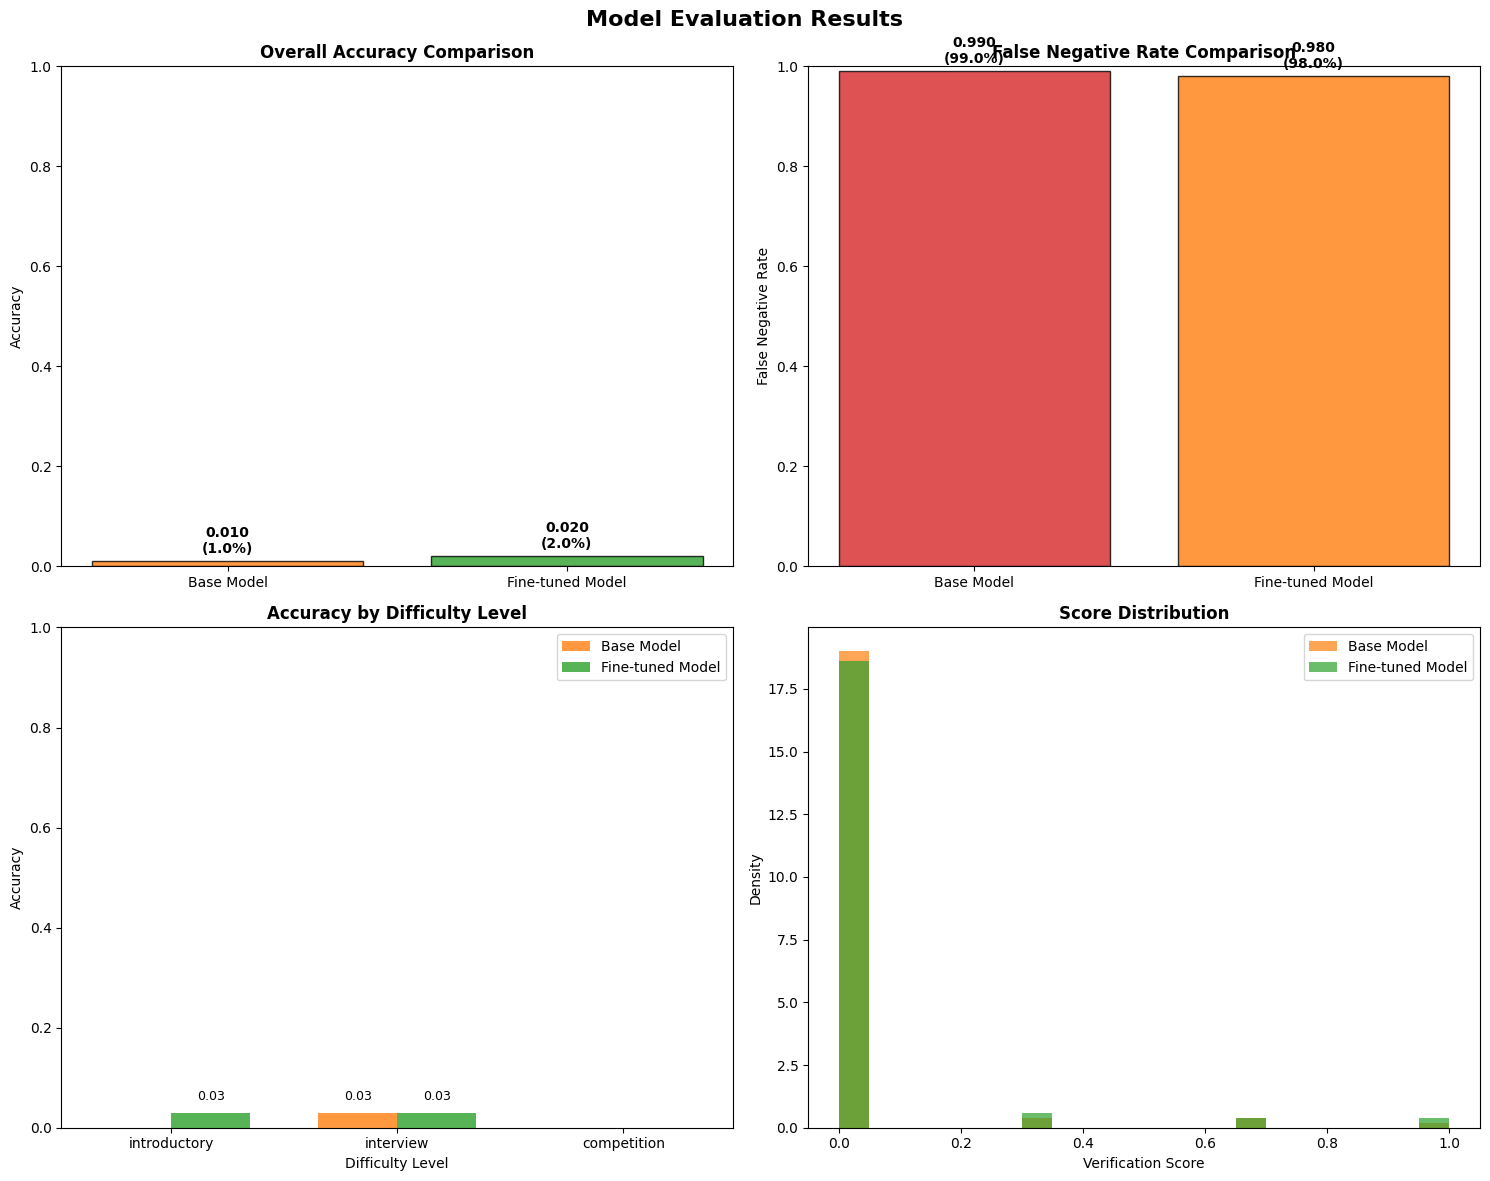

In [15]:
# =====================================================================
# STEP 9: Visualizations
# =====================================================================

print("\n📈 Creating visualizations...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

# 1. Overall Accuracy Comparison
ax1 = axes[0, 0]
models = ['Base Model', 'Fine-tuned Model']
accuracies = [base_metrics['accuracy'], finetuned_metrics['accuracy']]
colors = ['#ff7f0e', '#2ca02c']

bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Overall Accuracy Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}\n({acc*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 2. False Negative Rate Comparison
ax2 = axes[0, 1]
fnr_rates = [base_metrics['false_negative_rate'], finetuned_metrics['false_negative_rate']]

bars2 = ax2.bar(models, fnr_rates, color=['#d62728', '#ff7f0e'], alpha=0.8, edgecolor='black')
ax2.set_title('False Negative Rate Comparison', fontweight='bold')
ax2.set_ylabel('False Negative Rate')
ax2.set_ylim(0, 1)

for bar, fnr in zip(bars2, fnr_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{fnr:.3f}\n({fnr*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 3. Performance by Difficulty
ax3 = axes[1, 0]
difficulties = ['introductory', 'interview', 'competition']
base_accs = []
ft_accs = []

for diff in difficulties:
    if diff in base_metrics['by_difficulty']:
        base_accs.append(base_metrics['by_difficulty'][diff]['accuracy'])
    else:
        base_accs.append(0)
    
    if diff in finetuned_metrics['by_difficulty']:
        ft_accs.append(finetuned_metrics['by_difficulty'][diff]['accuracy'])
    else:
        ft_accs.append(0)

x = np.arange(len(difficulties))
width = 0.35

bars3_1 = ax3.bar(x - width/2, base_accs, width, label='Base Model', color='#ff7f0e', alpha=0.8)
bars3_2 = ax3.bar(x + width/2, ft_accs, width, label='Fine-tuned Model', color='#2ca02c', alpha=0.8)

ax3.set_title('Accuracy by Difficulty Level', fontweight='bold')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Difficulty Level')
ax3.set_xticks(x)
ax3.set_xticklabels(difficulties)
ax3.legend()
ax3.set_ylim(0, 1)

# Add value labels
for bars in [bars3_1, bars3_2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Score Distribution
ax4 = axes[1, 1]
base_scores = [r['score'] for r in base_results]
ft_scores = [r['score'] for r in finetuned_results]

ax4.hist(base_scores, bins=20, alpha=0.7, label='Base Model', color='#ff7f0e', density=True)
ax4.hist(ft_scores, bins=20, alpha=0.7, label='Fine-tuned Model', color='#2ca02c', density=True)
ax4.set_title('Score Distribution', fontweight='bold')
ax4.set_xlabel('Verification Score')
ax4.set_ylabel('Density')
ax4.legend()

plt.tight_layout()
plt.show()

In [16]:
# =====================================================================
# STEP 10: Sample Results Analysis
# =====================================================================

print("\n🔍 SAMPLE RESULTS ANALYSIS:")
print("="*60)

# Show some examples where fine-tuned model performed better
better_examples = []
for i, (base_res, ft_res) in enumerate(zip(base_results, finetuned_results)):
    if ft_res['success'] and not base_res['success']:
        better_examples.append((i, base_res, ft_res))

print(f"\n✅ Examples where Fine-tuned Model succeeded but Base Model failed: {len(better_examples)}")

if better_examples:
    print("\nShowing first 3 examples:")
    for i, (idx, base_res, ft_res) in enumerate(better_examples[:3]):
        print(f"\n--- Example {i+1} (Sample {idx}) ---")
        print(f"Problem: {base_res['problem']}")
        print(f"Difficulty: {base_res['difficulty']}")
        print(f"Base Model Score: {base_res['score']:.2f}")
        print(f"Fine-tuned Model Score: {ft_res['score']:.2f}")
        print(f"Fine-tuned Code Preview: {ft_res['generated_code'][:100]}...")

# Show examples where both failed
both_failed = []
for i, (base_res, ft_res) in enumerate(zip(base_results, finetuned_results)):
    if not ft_res['success'] and not base_res['success']:
        both_failed.append((i, base_res, ft_res))

print(f"\n❌ Examples where both models failed: {len(both_failed)}")

# Show examples where base was better (if any)
worse_examples = []
for i, (base_res, ft_res) in enumerate(zip(base_results, finetuned_results)):
    if base_res['success'] and not ft_res['success']:
        worse_examples.append((i, base_res, ft_res))

if worse_examples:
    print(f"\n⚠️ Examples where Base Model was better: {len(worse_examples)}")


🔍 SAMPLE RESULTS ANALYSIS:

✅ Examples where Fine-tuned Model succeeded but Base Model failed: 1

Showing first 3 examples:

--- Example 1 (Sample 89) ---
Problem: You are given an integer sequence A of length N.
Find the maximum absolute difference of two element...
Difficulty: introductory
Base Model Score: 0.00
Fine-tuned Model Score: 1.00
Fine-tuned Code Preview: n = int(input())
a = list(map(int, input().split()))
max_abs_diff = max([abs(a[i] - a[j]) for i in r...

❌ Examples where both models failed: 98



📋 DETAILED CLASSIFICATION ANALYSIS:

🔸 BASE MODEL Classification Report:
              precision    recall  f1-score   support

      Failed      0.000     0.000     0.000         0
  Successful      1.000     0.010     0.020       100

    accuracy                          0.010       100
   macro avg      0.500     0.005     0.010       100
weighted avg      1.000     0.010     0.020       100


🔸 FINE-TUNED MODEL Classification Report:
              precision    recall  f1-score   support

      Failed      0.000     0.000     0.000         0
  Successful      1.000     0.020     0.039       100

    accuracy                          0.020       100
   macro avg      0.500     0.010     0.020       100
weighted avg      1.000     0.020     0.039       100


📊 Confusion Matrices:


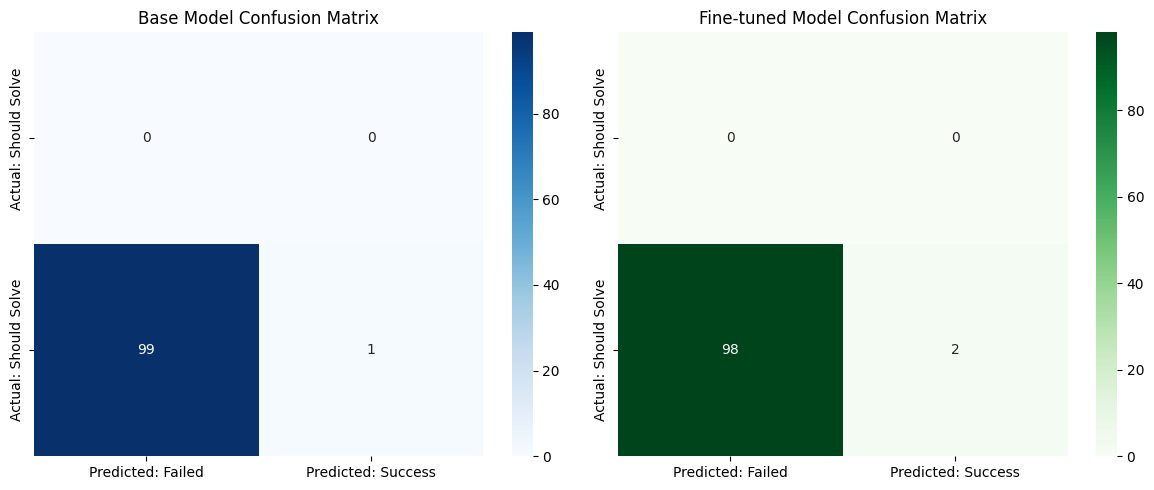

In [17]:
# =====================================================================
# STEP 11: Detailed Classification Report
# =====================================================================

print("\n📋 DETAILED CLASSIFICATION ANALYSIS:")
print("="*60)

# Create binary classification data for confusion matrix
base_predictions = [1 if r['success'] else 0 for r in base_results]
ft_predictions = [1 if r['success'] else 0 for r in finetuned_results]

# Assume ground truth is 1 for all (all problems should be solvable)
ground_truth = [1] * len(base_results)

print("\n🔸 BASE MODEL Classification Report:")
print(classification_report(ground_truth, base_predictions, 
                          target_names=['Failed', 'Successful'], 
                          digits=3))

print("\n🔸 FINE-TUNED MODEL Classification Report:")
print(classification_report(ground_truth, ft_predictions, 
                          target_names=['Failed', 'Successful'], 
                          digits=3))

# Confusion matrices
print("\n📊 Confusion Matrices:")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Base model confusion matrix
cm_base = confusion_matrix(ground_truth, base_predictions)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Predicted: Failed', 'Predicted: Success'],
            yticklabels=['Actual: Should Solve', 'Actual: Should Solve'])
ax1.set_title('Base Model Confusion Matrix')

# Fine-tuned model confusion matrix
cm_ft = confusion_matrix(ground_truth, ft_predictions)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Predicted: Failed', 'Predicted: Success'],
            yticklabels=['Actual: Should Solve', 'Actual: Should Solve'])
ax2.set_title('Fine-tuned Model Confusion Matrix')

plt.tight_layout()
plt.show()

In [18]:
# =====================================================================
# STEP 12: Statistical Significance Test
# =====================================================================

from scipy import stats

print("\n📈 STATISTICAL SIGNIFICANCE ANALYSIS:")
print("="*60)

# McNemar's test for paired binary classifications
def mcnemar_test(pred1, pred2, ground_truth):
    """Perform McNemar's test"""
    # Create contingency table
    both_correct = sum(1 for p1, p2, gt in zip(pred1, pred2, ground_truth) 
                      if p1 == gt and p2 == gt)
    only_first_correct = sum(1 for p1, p2, gt in zip(pred1, pred2, ground_truth) 
                            if p1 == gt and p2 != gt)
    only_second_correct = sum(1 for p1, p2, gt in zip(pred1, pred2, ground_truth) 
                             if p1 != gt and p2 == gt)
    both_wrong = sum(1 for p1, p2, gt in zip(pred1, pred2, ground_truth) 
                    if p1 != gt and p2 != gt)
    
    # McNemar's test statistic
    if only_first_correct + only_second_correct > 0:
        chi2_stat = (abs(only_first_correct - only_second_correct) - 1)**2 / (only_first_correct + only_second_correct)
        p_value = 1 - stats.chi2.cdf(chi2_stat, 1)
    else:
        chi2_stat = 0
        p_value = 1.0
    
    return {
        'both_correct': both_correct,
        'only_first_correct': only_first_correct,
        'only_second_correct': only_second_correct,
        'both_wrong': both_wrong,
        'chi2_statistic': chi2_stat,
        'p_value': p_value
    }

mcnemar_result = mcnemar_test(base_predictions, ft_predictions, ground_truth)

print("\n🧮 McNemar's Test Results:")
print(f"  Both models correct: {mcnemar_result['both_correct']}")
print(f"  Only base model correct: {mcnemar_result['only_first_correct']}")
print(f"  Only fine-tuned model correct: {mcnemar_result['only_second_correct']}")
print(f"  Both models wrong: {mcnemar_result['both_wrong']}")
print(f"  Chi-square statistic: {mcnemar_result['chi2_statistic']:.4f}")
print(f"  P-value: {mcnemar_result['p_value']:.4f}")

significance_level = 0.05
if mcnemar_result['p_value'] < significance_level:
    print(f"  ✅ Statistically significant improvement (p < {significance_level})")
else:
    print(f"  ⚠️ Not statistically significant (p >= {significance_level})")


📈 STATISTICAL SIGNIFICANCE ANALYSIS:

🧮 McNemar's Test Results:
  Both models correct: 1
  Only base model correct: 0
  Only fine-tuned model correct: 1
  Both models wrong: 98
  Chi-square statistic: 0.0000
  P-value: 1.0000
  ⚠️ Not statistically significant (p >= 0.05)


In [19]:
# =====================================================================
# STEP 13: Summary Report for Teacher
# =====================================================================

print("\n" + "="*60)
print("🎓 SUMMARY REPORT FOR TEACHER")
print("="*60)

print(f"""
📊 EVALUATION OVERVIEW:
  • Dataset: APPS (Automated Programming Problem Solving)
  • Evaluation Samples: {len(eval_dataset)}
  • Base Model: {config.base_model_name}
  • Fine-tuned Model: Custom fine-tuned version

📈 KEY RESULTS:
  
  ACCURACY:
  • Base Model: {base_metrics['accuracy']:.3f} ({base_metrics['accuracy']*100:.1f}%)
  • Fine-tuned Model: {finetuned_metrics['accuracy']:.3f} ({finetuned_metrics['accuracy']*100:.1f}%)
  • Improvement: {accuracy_improvement:+.3f} ({accuracy_improvement*100:+.1f} percentage points)
  
  FALSE NEGATIVE RATE:
  • Base Model: {base_metrics['false_negative_rate']:.3f} ({base_metrics['false_negative_rate']*100:.1f}%)
  • Fine-tuned Model: {finetuned_metrics['false_negative_rate']:.3f} ({finetuned_metrics['false_negative_rate']*100:.1f}%)
  • Reduction: {fnr_improvement:+.3f} ({fnr_improvement*100:+.1f} percentage points)
  
  VERIFICATION SCORES:
  • Base Model Average: {base_metrics['average_score']:.3f}
  • Fine-tuned Model Average: {finetuned_metrics['average_score']:.3f}
  • Improvement: {score_improvement:+.3f}

🎯 PERFORMANCE BY DIFFICULTY:""")

for diff in ['introductory', 'interview', 'competition']:
    if diff in base_metrics['by_difficulty'] and diff in finetuned_metrics['by_difficulty']:
        base_acc = base_metrics['by_difficulty'][diff]['accuracy']
        ft_acc = finetuned_metrics['by_difficulty'][diff]['accuracy']
        improvement = ft_acc - base_acc
        count = base_metrics['by_difficulty'][diff]['count']
        
        print(f"  • {diff.title()}: {base_acc:.3f} → {ft_acc:.3f} ({improvement:+.3f}) [{count} samples]")

print(f"""
📊 STATISTICAL ANALYSIS:
  • McNemar's Test P-value: {mcnemar_result['p_value']:.4f}
  • Statistical Significance: {"Yes" if mcnemar_result['p_value'] < 0.05 else "No"} (α = 0.05)
  • Cases where fine-tuned model was better: {mcnemar_result['only_second_correct']}
  • Cases where base model was better: {mcnemar_result['only_first_correct']}

🏆 CONCLUSION:
""")

if accuracy_improvement > 0.05:
    print("  ✅ SIGNIFICANT IMPROVEMENT: Fine-tuned model shows substantial gains")
elif accuracy_improvement > 0.01:
    print("  ✅ MODERATE IMPROVEMENT: Fine-tuned model shows measurable gains")  
elif accuracy_improvement > -0.01:
    print("  ⚠️ MINIMAL CHANGE: Fine-tuned model performs similarly to base model")
else:
    print("  ❌ PERFORMANCE DECLINE: Fine-tuned model underperforms base model")

if mcnemar_result['p_value'] < 0.05:
    print("  📈 The improvement is statistically significant")
else:
    print("  📊 The difference is not statistically significant")

print(f"""
💡 INSIGHTS:
  • Total problems successfully solved by fine-tuned model: {finetuned_metrics['successful']}/{finetuned_metrics['total_samples']}
  • False negative reduction: {fnr_improvement*100:.1f} percentage points
  • Best performance on: {max(finetuned_metrics['by_difficulty'].items(), key=lambda x: x[1]['accuracy'])[0] if finetuned_metrics['by_difficulty'] else 'N/A'} problems
  • Evaluation completed in reasonable time with representative sample size
""")


🎓 SUMMARY REPORT FOR TEACHER

📊 EVALUATION OVERVIEW:
  • Dataset: APPS (Automated Programming Problem Solving)
  • Evaluation Samples: 100
  • Base Model: codellama/CodeLlama-7b-Instruct-hf
  • Fine-tuned Model: Custom fine-tuned version

📈 KEY RESULTS:
  
  ACCURACY:
  • Base Model: 0.010 (1.0%)
  • Fine-tuned Model: 0.020 (2.0%)
  • Improvement: +0.010 (+1.0 percentage points)
  
  FALSE NEGATIVE RATE:
  • Base Model: 0.990 (99.0%)
  • Fine-tuned Model: 0.980 (98.0%)
  • Reduction: +0.010 (+1.0 percentage points)
  
  VERIFICATION SCORES:
  • Base Model Average: 0.030
  • Fine-tuned Model Average: 0.043
  • Improvement: +0.013

🎯 PERFORMANCE BY DIFFICULTY:
  • Introductory: 0.000 → 0.029 (+0.029) [34 samples]
  • Interview: 0.030 → 0.030 (+0.000) [33 samples]
  • Competition: 0.000 → 0.000 (+0.000) [33 samples]

📊 STATISTICAL ANALYSIS:
  • McNemar's Test P-value: 1.0000
  • Statistical Significance: No (α = 0.05)
  • Cases where fine-tuned model was better: 1
  • Cases where base mo

In [20]:
# =====================================================================
# STEP 14: Save Results to Files
# =====================================================================

print("\n💾 Saving detailed results...")

# Create results dataframe
results_data = []
for i, (base_res, ft_res) in enumerate(zip(base_results, finetuned_results)):
    results_data.append({
        'sample_id': i,
        'problem': base_res['problem'],
        'difficulty': base_res['difficulty'],
        'base_success': base_res['success'],
        'base_score': base_res['score'],
        'ft_success': ft_res['success'],
        'ft_score': ft_res['score'],
        'improvement': ft_res['score'] - base_res['score']
    })

results_df = pd.DataFrame(results_data)

# Save to CSV
results_df.to_csv('model_evaluation_results.csv', index=False)
print("✅ Detailed results saved to 'model_evaluation_results.csv'")

# Save summary metrics
summary_data = {
    'base_model_metrics': base_metrics,
    'finetuned_model_metrics': finetuned_metrics,
    'improvements': {
        'accuracy_improvement': accuracy_improvement,
        'fnr_reduction': fnr_improvement,
        'score_improvement': score_improvement
    },
    'statistical_test': mcnemar_result,
    'evaluation_config': {
        'eval_samples': len(eval_dataset),
        'base_model': config.base_model_name,
        'finetuned_model_path': config.finetuned_model_path
    }
}

with open('evaluation_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2, default=str)
print("✅ Summary metrics saved to 'evaluation_summary.json'")


💾 Saving detailed results...
✅ Detailed results saved to 'model_evaluation_results.csv'
✅ Summary metrics saved to 'evaluation_summary.json'
